<a href="https://colab.research.google.com/github/exponentialR/DeepLearningFundamentals/blob/main/Classification_FashionMNISTipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision 

#Data loading and transforming 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader 
from torchvision import transforms 

#Since the output of torchvision datasets are PIL images of range [0, 1], they need to be turned into corresponding tensors 
#for training the CNN

data_transform = transforms.ToTensor()
train_data = FashionMNIST(root ='./data', train = True, download = True, transform = data_transform)

test_data = FashionMNIST(root='./data', train = False, download = True, transform= data_transform)

#print out the statistics about the training and test data 
print('Train data, number of images: ', len(train_data))
print('Test data, number of images:', len(test_data))


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train data, number of images:  60000
Test data, number of images: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [21]:
batch_size = 5 
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = True)

#specify the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

ValueError: ignored

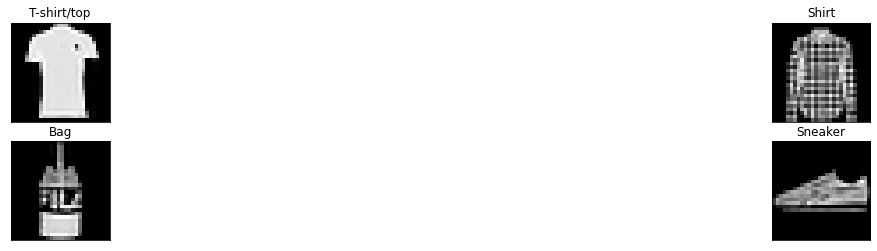

In [22]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [23]:
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        #self.conv3 = nn.Conv2d(20, 30, 3)

        self.fc1 = nn.Linear(20*5*5, 50)
        
        #dropout with p = 0.4
        self.fc1_drop = nn.Dropout(p = 0.4)
        #create 10 output channels (for 10 classes )
        
        self.fc2= nn.Linear(50, 10)
        
    #Define the feedforward behaviour 
    def forward(self, x):
    #conv/relu + pool layers 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))

        #prep for Linear layer 
        #Flatten the layers
        x = x.view(x.size(0), -1)

        #two linear layers with dropout in between 
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [24]:
#Specify the loss Function and Optimiser
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [25]:
#Calculate the accuracy of the before training 
correct = 0
total = 0

for images, labels in test_loader:
    
    outputs = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total +=labels.size(0)
    correct +=(predicted ==labels).sum()
#calculate the accuracy 
#convert correct from a Tensor to a scaler using dictionary .item()

accuracy = 100.0 * correct.item()/total

print('Accuracy before training: ', accuracy)

Accuracy before training:  9.71


In [26]:
#Train the Network 

def train(n_epochs):
    loss_over_time = []
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if batch_i %1000 ==999: #print every 1000 batches
                avg_loss = running_loss/1000
                #record and print the average loss pver 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch:{}, Average Loss: {}'. format(epoch +1, batch_i+1, avg_loss))
                running_loss = 0.0
        print('Finished Training')
        return loss_over_time

In [27]:
n_epochs = 100
training_loss = train(n_epochs)

Epoch: 1, Batch:1000, Average Loss: 2.1580179062485696
Epoch: 1, Batch:2000, Average Loss: 1.1187839850187302
Epoch: 1, Batch:3000, Average Loss: 0.9186035036407411
Epoch: 1, Batch:4000, Average Loss: 0.8155293598398566
Epoch: 1, Batch:5000, Average Loss: 0.783296085909009
Epoch: 1, Batch:6000, Average Loss: 0.7002705295272171
Epoch: 1, Batch:7000, Average Loss: 0.6738819939317182
Epoch: 1, Batch:8000, Average Loss: 0.6734469114299864
Epoch: 1, Batch:9000, Average Loss: 0.6380376847032457
Epoch: 1, Batch:10000, Average Loss: 0.6264493741039187
Epoch: 1, Batch:11000, Average Loss: 0.6012991333771497
Epoch: 1, Batch:12000, Average Loss: 0.5886560219107195
Finished Training
